# Medical Expenditure Panel Survey

In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

from aix360.datasets import MEPSDataset

from dalex import explainer

In [4]:
data = MEPSDataset().data()

In [5]:
data.reset_index(drop=True, inplace=True)

In [6]:
data.drop(columns= ['PANEL', 'PERSONWT'], inplace=True)

In [7]:
data.describe(include='all')

,REGION,AGE31X,GENDER,RACE3,MARRY31X,EDRECODE,FTSTU31X,ACTDTY31,HONRDC31,RTHLTH31,...,ADSMOK42,PCS42,MCS42,K6SUM42,PHQ242,EMPST31,POVCAT15,INSCOV15,INCOME_M,HEALTHEXP
count,18350.000000,18350.000000,18350.000000,18350.000000,18350.000000,18350.000000,18350.000000,18350.000000,18350.000000,18350.000000,...,18350.000000,18350.000000,18350.000000,18350.000000,18350.000000,18350.000000,18350.000000,18350.000000,18350.000000,18350.000000
mean,2.607466,38.746649,0.521526,0.338147,3.590954,9.842943,-0.759619,2.638692,2.156948,2.177929,...,0.900926,32.348196,34.368819,1.664687,0.136948,1.526376,3.510627,1.446921,27853.695313,5184.511608
std,0.942848,23.020492,0.499550,0.473092,2.262703,6.226279,0.855099,0.813550,0.523573,1.095924,...,1.355978,25.021569,25.934907,4.106635,1.329289,1.842521,1.461804,0.624748,36225.013969,15126.748532
min,1.000000,0.000000,0.000000,0.000000,1.000000,-1.000000,-1.000000,1.000000,1.000000,-1.000000,...,-1.000000,-9.000000,-9.000000,-9.000000,-1.000000,-1.000000,1.000000,1.000000,0.000000,0.000000
25%,2.000000,19.000000,0.000000,0.000000,1.000000,2.000000,-1.000000,2.000000,2.000000,1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,3.000000,1.000000,0.000000,198.000000
50%,3.000000,38.500000,1.000000,0.000000,5.000000,13.000000,-1.000000,2.000000,2.000000,2.000000,...,2.000000,43.310000,46.735000,0.000000,0.000000,1.000000,4.000000,1.000000,16200.000000,1034.000000
75%,3.000000,57.000000,1.000000,1.000000,5.000000,14.000000,-1.000000,3.000000,2.000000,3.000000,...,2.000000,55.090000,57.060000,3.000000,0.000000,4.000000,5.000000,2.000000,40000.000000,4219.500000
max,4.000000,85.000000,1.000000,1.000000,10.000000,16.000000,3.000000,4.000000,4.000000,5.000000,...,2.000000,71.060000,74.980000,24.000000,6.000000,4.000000,5.000000,3.000000,320299.000000,659952.000000


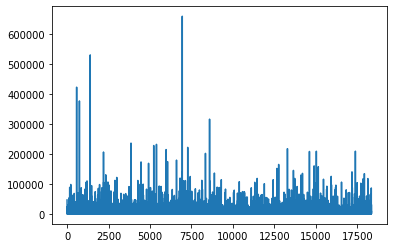

In [8]:
plt.plot(data.HEALTHEXP)

In [9]:
X, y = data.drop({'HEALTHEXP'}, 1), data['HEALTHEXP']

In [10]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=37)

In [11]:
y.describe(percentiles=np.linspace(0.1, 0.9, 9))

count     18350.000000
mean       5184.511608
std       15126.748532
min           0.000000
10%           0.000000
20%         114.000000
30%         302.000000
40%         585.000000
50%        1034.000000
60%        1784.800000
70%        3099.000000
80%        5619.800000
90%       12591.100000
max      659952.000000
Name: HEALTHEXP, dtype: float64

In [12]:
def score_r2_print(clf, X_train, X_test, y_train, y_test):
    print('Training R^2:', r2_score(y_train, clf.predict(X_train)))
    print('Test R^2:', r2_score(y_test, clf.predict(X_test)))

## Train GradientBoostingRegressor

In [13]:
# Train and evaluate GBRT
gbr = GradientBoostingRegressor(n_estimators=500, random_state=0)
gbr.fit(X_train_raw, y_train)

score_r2_print(gbr, X_train_raw, X_test_raw, y_train, y_test)

Training R^2: 0.6731005507461095
Test R^2: 0.13637817020720355


This model overfits on training data.

## Train Linear Rule Regressor

In [14]:
regressor = LinearRegression()
regressor.fit(X_train_raw, y_train)

score_r2_print(regressor, X_train_raw, X_test_raw, y_train, y_test)

Training R^2: 0.1385134639453851
Test R^2: 0.15861900854440303


## 3. EXPLAINING

## GradientBoostingRegressor

### 3.GBM.1 Shapley

In [19]:
exp = explainer.Explainer(model=gbr, data=X_train_raw, y=y_train, model_type='regression')
exp_shap_gbr = exp.predict_parts(X_train_raw.iloc[0], type='shap')
exp_shap_gbr.plot(max_vars=42)

Preparation of a new explainer is initiated

  -> label             : not specified, model's class taken instead!
  -> data              : 12845 rows 43 cols
  -> target variable   :  Argument 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 12845 values
  -> predict function  : <function yhat.<locals>.<lambda> at 0x150006b00> will be used
  -> predicted values  : min = -5490.438225765241, mean = 5212.38349552355, max = 597900.6633324702
  -> residual function : difference between y and yhat
  -> residuals         : min = -47259.18472204638, mean = 2.7415830947954676e-13, max = 179795.95387093432
  -> model_info        : package sklearn

A new explainer has been created!


<img src="img/exp_shap_gbr.png">

### 3.GBM.2  BreakDown

In [20]:
exp = explainer.Explainer(model=gbr, data=X_train_raw, y=y_train, model_type='regression')
exp_bd_gbr = exp.predict_parts(X_train_raw.iloc[0], type='break_down')
exp_bd_gbr.plot(max_vars=42)

Preparation of a new explainer is initiated

  -> label             : not specified, model's class taken instead!
  -> data              : 12845 rows 43 cols
  -> target variable   :  Argument 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 12845 values
  -> predict function  : <function yhat.<locals>.<lambda> at 0x1511c49e0> will be used
  -> predicted values  : min = -5490.438225765241, mean = 5212.38349552355, max = 597900.6633324702
  -> residual function : difference between y and yhat
  -> residuals         : min = -47259.18472204638, mean = 2.7415830947954676e-13, max = 179795.95387093432
  -> model_info        : package sklearn

A new explainer has been created!


<img src="img/exp_bd_gbr.png">

## LinarRegression

### 3.LR.1 Shapley

In [21]:
exp = explainer.Explainer(model=regressor, data=X_train_raw, y=y_train, model_type='regression')
exp_shap_lr = exp.predict_parts(X_train_raw.iloc[0], type='shap')
exp_shap_lr.plot(max_vars=44)

Preparation of a new explainer is initiated

  -> label             : not specified, model's class taken instead!
  -> data              : 12845 rows 43 cols
  -> target variable   :  Argument 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 12845 values
  -> predict function  : <function yhat.<locals>.<lambda> at 0x150889e60> will be used
  -> predicted values  : min = -6368.615923671579, mean = 5212.383495523545, max = 33625.964913592914
  -> residual function : difference between y and yhat
  -> residuals         : min = -30202.729492857383, mean = 4.01494648262609e-12, max = 648175.1990382974
  -> model_info        : package sklearn

A new explainer has been created!


/Users/piotrpodolski/Desktop/projects/IML/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<img src="img/exp_shap_lr.png">

### 3.LR.2 BreakDown

In [22]:
exp = explainer.Explainer(model=regressor, data=X_train_raw, y=y_train, model_type='regression')
exp_bd_lr = exp.predict_parts(X_train_raw.iloc[0], type='break_down')
exp_bd_lr.plot(max_vars=42)

Preparation of a new explainer is initiated

  -> label             : not specified, model's class taken instead!
  -> data              : 12845 rows 43 cols
  -> target variable   :  Argument 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 12845 values
  -> predict function  : <function yhat.<locals>.<lambda> at 0x151117dd0> will be used
  -> predicted values  : min = -6368.615923671579, mean = 5212.383495523545, max = 33625.964913592914
  -> residual function : difference between y and yhat
  -> residuals         : min = -30202.729492857383, mean = 4.01494648262609e-12, max = 648175.1990382974
  -> model_info        : package sklearn

A new explainer has been created!


<img src="img/exp_bd_lr.png">